# Schooling under Predation

#### TUE NGO - AARUSHI SHARMA - MARIO TSAVALOS

System Design, Integration & Control - CSIM 2020/2021

![title](./cover.jpg)

# I - Introduction

In the natural world, animals exhibit collective behaviors by traveling in groups in a coordinated manner. This phenomenon occurs at both microscopic scales (bacteria) and macroscopic scales (vertebrates). It is called ***schooling*** in the case of fish, ***flocking*** in the case of birds, and ***herding*** in the case of grazing mammals. Any group of fish that stay together and swim in the same direction is schooling. 

Schooling helps fish to defend against predators and enhance foraging success. Using computers, those schooling behaviors of fish can be simulated by creating simple rules and combining them. This is known as emergent behavior and can be used to simulate representational group movements. We chose to simulate the behaviors of a school of mackerels under the predation of a shark.

# II - State of the art

The simulation and modeling of animal collaborative behaviors have been investigated by many researchers. This flock motion seems simple and yet is visually complex. In his infamous work **“Flocks, Herds, and Schools: A Distributed Behavioral Model”**, Craig W. Reynolds explores flock movement as the aggregate result of the actions of individual animals, each acting exclusively based on the basis of its own local perception of the world. Reynolds developed a computational model of bird flocks and fish schools in this regard. The basic **flocking** model comprises three steering behaviors that explain how an individual maneuvers based on the location and velocity of its neighbors. 

> ***1. Separation***: avoid collision amongst mates of the same group

> ***2. Alignment***: steer towards the average heading of local mates 

> ***3. Cohesion***: steer towards the centroid of the mass to stay close to nearby mates
    
More information: https://www.red3d.com/cwr/boids/.

![title](./boids.png)

In this project scenario, we will also focus on the behaviors of an individual mackerel as reactive responses to the presence of other mackerels or a predator (shark). We took inspiration from these rules to implement the schooling behaviors with some modifications.

# III - Robotic simulation setup

![title](./scene-1.png)

*Our V-REP scene with 3 epucks on the top-left corner as 3 mackerels and the shark locates on the bottom-right corner.*

## 1 - Initialize session

In [1]:
from simulator_interface import open_session, close_session
simulator, prey1, prey2, prey3, predator = open_session(n_epucks=4)


In [2]:
# make sure to detach all behaviors and make all the robots stop
for e in simulator.robots:
    e.detach_all_behaviors()
    e.stop()
    

In [ ]:
# in case something goes wrong
close_session(simulator)


## 2 - Define species, motor constraints and internal states

In [3]:
predator.species = "shark"
prey1.species = "mackerel"
prey2.species = "mackerel"
prey3.species = "mackerel"


### Constraints on motor skills

We would like to apply different musculoskeletal constraints to different species. This helps us to easily distinguish the predator and the preys (they are all epucks in the simulator scene), and also reflects a reality in nature.

In [4]:
predator.max_speed = 15.0
prey1.max_speed = 10.0
prey2.max_speed = 10.0
prey3.max_speed = 10.0


### Variables for internal states

We would like to specify the weight of each behavior while they are running in parallel on the same robot, i.e. how much it will count in the averaging. This weighting can activate a behavior according to some internal states of the robot, i.e. the animal will choose to satiate the need with higher intensity/urgency. The animal then evaluates the importance of needs based on a ranking system to represent the trade-offs when there are multiple needs with equal intensities. 

The relationship between behavior weighting, internal states and the relative importance of needs can be simplified as this equation:

> ***Behavior weight = Intensity of need - Importance discount***


To do so, first we need to define the basic needs of both mackerels and sharks:

In [5]:
# the need to stay close to shoal mates
# regulate schooling behaviors

prey1.collaboration_need = 0.5
prey2.collaboration_need = 0.5
prey3.collaboration_need = 0.5

# cohesion threshold - a proximity value smaller than this means the shoal mate is too far away
th_c_min = 0.4
# separation threshold - a proximity value bigger than this means the shoal mate is too close
th_c_max = 0.6


In [6]:
# the need to run away from predator
# regulate escaping behaviors

prey1.security_need = 0.5
prey2.security_need = 0.5
prey3.security_need = 0.5


In [7]:
# regulate foraging behaviors: low energy level increases the need to catch food
predator.energy_level = 0.5
prey1.energy_level = 0.5
prey2.energy_level = 0.5
prey3.energy_level = 0.5

# predator has higher metabolic rate
predator.energy_increase = 0.2
predator.energy_decay = 0.02

# preys have lower metabolic rate
prey1.energy_increase = 0.1
prey1.energy_decay = 0.01
prey2.energy_increase = 0.1
prey2.energy_decay = 0.01
prey3.energy_increase = 0.1
prey3.energy_decay = 0.01


### Ranking system of needs

The animal evaluates the importance of needs based on a ranking system. We prioritize the schooling behaviors over anti-predation and foraging in the context of this project, while in reality it could be different.

The predator is only affected by its hunger, thus, there is no ranking system for it.

In [8]:
# act as a value to be subtracted from the intensity of need
# the higher the importance, the lower the deduction value

# first priority
prey1.collaboration_discount = 0.01
prey2.collaboration_discount = 0.01
prey3.collaboration_discount = 0.01

# second priority
prey1.security_discount = 0.02
prey2.security_discount = 0.02
prey3.security_discount = 0.02

# third priority
prey1.foraging_discount = 0.03
prey2.foraging_discount = 0.03
prey3.foraging_discount = 0.03


## 3 - Define routines to track internal states

These routines - which we call ***drives*** - helps the robot keep track of its internal states and calculate the intensity of certain needs. We adjust the intensity of need based on the intensity of threats caused by the fluctuations of external stimuli. In some cases, the animal will act in order to keep this value around the central point of 0.5. In other cases, the animal will try to keep this value within a desired, predefined range.

In [9]:
# affected by the presence of shoal mates 
# adjusting collaboration need 

def schooling_drive(robot): 
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True)
    left_species, right_species = robot.sensed_epuck_attributes(epuck_left, epuck_right, "species", default_value ="none")
    
    # process the appropriate input
    if left_species != "mackerel":
        left = 0
    if right_species != "mackerel":
        right = 0
    
    # ensure distance to shoal mates to be within a range between cohesion and separation thresholds
    if left <= th_c_min: # the shoal mate is too close
        robot.collaboration_need += abs(robot.collaboration_need - left) # increase the need
    if right <= th_c_min: # the shoal mate is too close 
        robot.collaboration_need += abs(robot.collaboration_need - right) # increase the need
    if left >= th_c_max: # the shoal mate is too far 
        robot.collaboration_need -= abs(robot.collaboration_need - left) # decrease the need
    if right >= th_c_max: # the shoal mate is too far 
        robot.collaboration_need -= abs(robot.collaboration_need - right) # decrease the need

    robot.collaboration_need = min(1., max(robot.collaboration_need, 0.))
    

In [10]:
# affected by the presence of the predator 
# adjusting security need

def security_drive(robot): 
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True)
    left_species, right_species = robot.sensed_epuck_attributes(epuck_left, epuck_right, "species", default_value ="none")
    
    # process the appropriate input
    if left_species != "shark":
        left = 0
    if right_species != "shark":
        right = 0
    
    # ensure the predator to be as far as possible
    robot.security_need = left + right 
    
    robot.security_need = min(1., max(robot.security_need, 0.))
    

In [11]:
# affected by energy level and adjusting energy level
# for both prey and predators

def foraging_drive(robot): 
    if robot.has_eaten():
        robot.energy_level += robot.energy_increase
    else:
        robot.energy_level -= robot.energy_decay  
        
    robot.energy_level = min(1., max(robot.energy_level, 0.))
    

## 4 - Reynolds-like schooling behaviors

### Rule of Separation:  `separation()`

Collision avoidance is the desire of a mackerel to steer away from an approaching schoal mate. In Reynolds' work, static collision avoidance and dynamic velocity matching are corresponding to each other. Together they guarantee that the individuals of a simulated group are free to navigate without running into each other. Static collision avoidance depends on the relative position of the shoal mates and disregards their velocities. The coordinating velocity of the animal is based only on velocity and ignores position. Static collision avoidance serves to build up the minimum required separation distance, while velocity coordination generally tends to maintain it.

In our case, we developed this behavior based on the basic `fear` Braitenbergs behavior. The distances to shoal mates are proximity values detected by the two proximity sensors of the robot. The velocity of a wheel will be mapped to the values of the sensor at the same side of the robot in an excitatory manner. The robot tends to steer away faster from a shoal mate when there is a higher chance of collision and slow down when reaching a safe separation distance. 

The weight of this behavior is modulated by the collaboration need (the closer the shoal mates, the lower the collaboration need, the **higher** the weight), and finally we applied a global discount to the whole group of schooling behaviors.

In [12]:
def separation(robot):
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True)
    left_species, right_species = robot.sensed_epuck_attributes(epuck_left, epuck_right, "species", default_value ="none")
    
    # process the appropriate input
    if left_species != "mackerel":
        left = 0
    if right_species != "mackerel":
        right = 0
    
    # process the appropriate activation value
    left_activation = left 
    right_activation = right 
    
    # calculate the weight 
    weight = min(1., max((1 - robot.collaboration_need - robot.collaboration_discount), 0.))
    
    return left_activation, right_activation, weight


### Rule of Cohesion: `cohesion()` 

This rule causes the animal to move in a direction that moves it closer to the centroid of the nearby shoal mates. In Reynolds' work, if the group is maintained stable, the distance to shoal mates is approximately the same in all directions. In this case, the shoal centering urge is small. If a mackerel is on the boundary of the shoal, its neighbors are on one side. The centroid of the local shoal mates is displaced from the center of the neighbors toward the body of the shoal. Here the centering urge is stronger.

In our case, we developed this behavior partially based on the basic `love` Braitenbergs behavior. The distances to shoal mates are proximity values detected by the two proximity sensors of the robot. The velocity of a wheel will be mapped to the values of the sensor at the same side of the robot in an inhibitory manner. The robot will try to approach the shoal mates faster if it's too far away from them and slows down when it gets closer.

The weight of this behavior is also modulated by the collaboration need (the closer the shoal mates, the lower the collaboration need, the **lower** the weight), and finally we applied a global discount to the whole group of schooling behaviors.

In [13]:
def cohesion(robot):
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True) 
    left_species, right_species = robot.sensed_epuck_attributes(epuck_left, epuck_right, "species", default_value ="none")
    
    # process the appropriate input
    if left_species != "mackerel":
        left = 0
    if right_species != "mackerel":
        right = 0
    
    # process the appropriate activation value
    left_activation = 1 - left 
    right_activation = 1 - right 
    
    # calculate the weight
    weight = min(1., max((robot.collaboration_need - robot.collaboration_discount), 0.))
    
    return left_activation, right_activation, weight


### Rule of Alignment: `alignment()`

We developed this rule in order to complement the `cohesion` rule regarding the centering movement towards the centroid of local shoal mates as well as to make sure all the members will have the tendency to navigate in the average heading of the shoal. 

In previous works, this rule is usually calculated based on the global direction and central point of the flock as some sort of vectors. In our case, we calculated the moving direction of neighbors by comparing the immediate proximity value and the previous proximity value. The mackerel who goes in the opposite direction with the other 2 mates will be the one who needs to change its direction and follow the majority. We also allowed this rule to have the highest weight among the schooling behaviors, and finally, we applied the global discount.

We observe that this behavior indeed helps the member steering towards the center point of the local mates and moving towards the average heading of them. But it cannot ensure that all the members will move in the same direction all the time (sometimes they will).

In [14]:
def alignment(robot):
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True)
    left_species, right_species = robot.sensed_epuck_attributes(epuck_left, epuck_right, "species", default_value ="none")
    
    # process the appropriate input
    if left_species != "mackerel":
        left = 0
    if right_species != "mackerel":
        right = 0
    
    # save the previous readings
    prev_left = left
    prev_right = right
    
    # get new readings
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True)
    left_species, right_species = robot.sensed_epuck_attributes(epuck_left, epuck_right, "species", default_value ="none")
    
    if left_species != "mackerel":
        left = 0
    if right_species != "mackerel":
        right = 0
    
    # process the appropriate activation value based on the comparision of readings 
    if (prev_left - left) < 0 and (prev_right - right) < 0: # both other shoal mates are going towards the robot
        # the robot rotates to change direction 
        left_activation = 0
        right_activation = 1
    else:
        # switch off this behavior
        left_activation = 0
        right_activation = 0
    
    # always has highest weight among schooling behaviors
    return left_activation, right_activation, 1 - robot.collaboration_discount


We also notice that the epucks only have 2 sensors in front of it, which may cause them unable to detect mates out of the local sight. Other mates will tend to ignore the lost one. The lost animal needs to look for the group by rotating itself until one of the mates are within sight. 

In [15]:
def mate_finding(robot):
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True)
    left_species, right_species = robot.sensed_epuck_attributes(epuck_left, epuck_right, "species", default_value ="none")
    
    # process the appropriate input
    if left_species != "mackerel":
        left = 0
    if right_species != "mackerel":
        right = 0
    
    # process the appropriate activation value based on the distance of shoal mates 
    if left == 0 and right == 0: # losing sight of both shoal mates
        # rotate until one of the shoal mates are within sight
        left_activation = 0
        right_activation = 1
    else:
        # switch off this behavior
        left_activation = 0
        right_activation = 0
    
    # always has highest weight among schooling behaviors
    return left_activation, right_activation, 1 - robot.collaboration_discount


![title](./scene-school-1.png)

*The 3 mackerels demonstrating schooling behavior, eventually form a triangular group.*

## 5 - Other behaviors

![title](./scene-2.png)

*Schooling in the presence of spheres and predators.*

### Avoiding environmental obstacles: `obstacle_avoidance()` 

Real flocks and schools sometimes split apart to go around an obstacle. We developed this behavior based on the basic `shy()` Braitenbergs behavior. The distances to objects (corals, walls, pillars, etc. ) are proximity values detected by the two proximity sensors of the robot. A wheel will be cross-wired to the sensor at the opposite side of the robot in an inhibitory manner. We allowed this rule to have the highest weight among all behaviors.


In [16]:
# always has highest global weight among all behaviors 
# for both prey and predators

def obstacle_avoidance(robot):
    left, right = robot.prox_activations(tracked_objects=["20cm", "Coral", "Cup"]) 
    left_activation = 1 - right
    right_activation = 1 - left 
    return left_activation, right_activation


### Anti-predation behaviors: `escape()` 

The anti-predation behaviors depend on the intensity of threat (security need). The weight of this behavior is modulated by the security need (the closer the predator, the higher the security need, the higher the weight), and finally, we applied a global discount to the anti-predation behaviors.

The mackerels will flee while trying to stay within-group or split apart and then reunite based on whether which need is more intense: security or collaboration.

In [17]:
def escape(robot):
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True)
    left_species, right_species = robot.sensed_epuck_attributes(epuck_left, epuck_right, "species", default_value ="none")
    
    # process the appropriate input
    if left_species != "shark":
        left = 0
    if right_species != "shark":
        right = 0
    
    # process the appropriate activation value
    left_activation = left 
    right_activation = right 
    
    # calculate the weight 
    weight = min(1., max((robot.security_need - robot.security_discount), 0.))
    
    return left_activation, right_activation, weight


![title](./scene-pred-3.png)

*Each mackerel try to steer away from the predator for its own sake and eventually split apart.*

![title](./scene-school-2.png)

*They perform grouping again when the predator is out of sight.*

### Foraging behaviors: `sphere_catching()`, `sphere_ignoring()` and `prey_hunting()` 

The foraging behaviors depend on the animal's hunger (energy level). The weight of this behavior is modulated by the energy level (the lower the energy level, the higher the foraging need, the **higher** the weight), and finally we applied a global discount to the foraging behaviors.

When the animal is full, it tends to ignore and steer away from spheres. The weight of this behavior is also modulated by the energy level (the lower the energy level, the higher the foraging need, the **lower** the weight), and finally we applied a global discount to the foraging behaviors.

The predator is allowed to catch spheres too in order to keep it alive.

In [18]:
def sphere_catching(robot):
    left, right = robot.prox_activations(tracked_objects=["Sphere"])
    
    left_activation = right
    right_activation = left
    
    weight = 1 - robot.energy_level
    
    # apply foraging discount in the case of mackerel
    if robot.species == "mackerel":
        weight -= robot.foraging_discount
        
    return left_activation, right_activation, min(1., max(weight, 0.))

def sphere_ignoring(robot):
    left, right = robot.prox_activations(tracked_objects=["Sphere"])
    
    left_activation = left
    right_activation = right
    
    weight = robot.energy_level
    
    # apply foraging discount in the case of mackerel
    if robot.species == "mackerel":
        weight -= robot.foraging_discount
        
    return left_activation, right_activation, min(1., max(weight, 0.))


![title](./scene-forage-1.png)

*The mackerels try to catch detected food but still spend efforts in staying within group.*

![title](./scene-forage-2.png)

*They become more aggressive towards food over time and split apart to forage.*

In nature, the predator also regulates its hunting behavior by the number of prey in a group: it will target the lonely fish rather than a collaborative school. We would like to demonstrate this in the project as it justifies why we highlight the high importance of collaboration. Thus, the weight is calculated base on the energy level as well as the risk the predator has to tolerate while hunting. 

In [19]:
def prey_hunting(robot):
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True)
    left_species, right_species = robot.sensed_epuck_attributes(epuck_left, epuck_right, "species", default_value ="none")
    
    # process the appropriate input and detect the number of preys
    prey_detected = 0
    if left_species == "mackerel":
        prey_detected += 1
    else:
        left = 0
    if right_species == "mackerel":
        prey_detected += 1
    else:
        right = 0
    
    left_activation = right 
    right_activation = left  
    
    # calculate the weight, taking into account the risk of hunting multiple preys
    risk = 0.5 if prey_detected > 1 else 0
    weight = min(1., max((1 - robot.energy_level - risk), 0.))
    
    return left_activation, right_activation, weight


![title](./scene-pred-1.png)

*The lonely mackerel is likely to be targeted by the predator.*

![title](./scene-pred-2.png)

*Gotcha!*

## 6 - Collect data for plotting

In [20]:
def robot_log(robot):
    robot.add_log("foraging", 1 - robot.energy_level)
    robot.add_log("position", robot.position())
    if robot.species == "mackerel":
        robot.add_log("collaboration", robot.collaboration_need)
        robot.add_log("security", robot.security_need)
        

# IV - Simulation execution

## 1 - Environmental dynamics

In [21]:
simulator.start_sphere_apparition(period=5)


Routine sphere_apparition started
Routine eating started


In [23]:
simulator.stop_sphere_apparition()


Routine sphere_apparition stopped
Routine eating stopped


## 2 - Attach and start all routines and behaviors

In [22]:
for e in simulator.robots:
    e.attach_behavior(sphere_catching, freq=10)
    e.attach_behavior(sphere_ignoring, freq=10)
    e.attach_behavior(obstacle_avoidance, freq=10)
    e.attach_routine(foraging_drive, freq=1)
    e.attach_routine(robot_log, freq=1)
    e.start_routine(robot_log)
    e.start_routine(foraging_drive)
    
    if e.species == "mackerel":
        
        e.attach_behavior(obstacle_avoidance, freq=10)
        
        e.attach_routine(schooling_drive, freq=1)
        e.attach_routine(security_drive, freq=1)
        e.attach_behavior(cohesion, freq=10)
        e.attach_behavior(separation, freq=10)
        e.attach_behavior(alignment, freq=10)
        e.attach_behavior(mate_finding, freq=10)
        e.attach_behavior(escape, freq=10)
        e.start_routine(schooling_drive)
        e.start_routine(security_drive)
    
    if e.species == "shark":
        e.attach_behavior(prey_hunting, freq=10)

Routine robot_log started
Routine foraging_drive started
Routine schooling_drive started
Routine security_drive started
Routine robot_log started
Routine foraging_drive started
Routine schooling_drive started
Routine security_drive started
Routine robot_log started
Routine foraging_drive started
Routine schooling_drive started
Routine security_drive started
Routine robot_log started
Routine foraging_drive started


In [23]:
for e in simulator.robots: 
    e.start_all_behaviors()
    

Behavior sphere_catching started
Behavior sphere_ignoring started
Behavior obstacle_avoidance started
Behavior cohesion started
Behavior separation started
Behavior alignment started
Behavior mate_finding started
Behavior escape started
Behavior sphere_catching started
Behavior sphere_ignoring started
Behavior obstacle_avoidance started
Behavior cohesion started
Behavior separation started
Behavior alignment started
Behavior mate_finding started
Behavior escape started
Behavior sphere_catching started
Behavior sphere_ignoring started
Behavior obstacle_avoidance started
Behavior cohesion started
Behavior separation started
Behavior alignment started
Behavior mate_finding started
Behavior escape started
Behavior sphere_catching started
Behavior sphere_ignoring started
Behavior obstacle_avoidance started
Behavior prey_hunting started


## 2 - Plot data

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'Position Y')

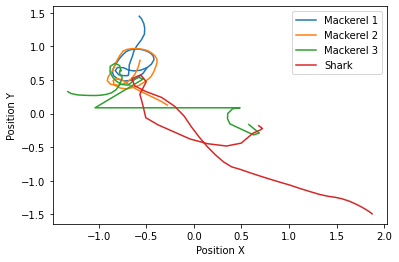

In [30]:
%pylab inline
import numpy as np

paths = [np.array(e.get_log('position')) for e in simulator.robots]

for path in paths:
    plot(path[:, 0], path[:, 1])
legend(["Mackerel 1", "Mackerel 2", "Mackerel 3", "Shark"])
    
xlabel("Position X")
ylabel("Position Y")

Text(0, 0.5, 'Need')

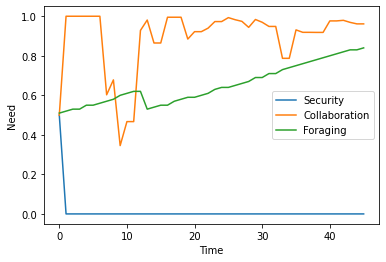

In [26]:
plot(prey1.get_log("security"))
plot(prey1.get_log("collaboration"))
plot(prey1.get_log("foraging"))
legend(["Security", "Collaboration", "Foraging"])

xlabel("Time")
ylabel("Need")

Text(0, 0.5, 'Need')

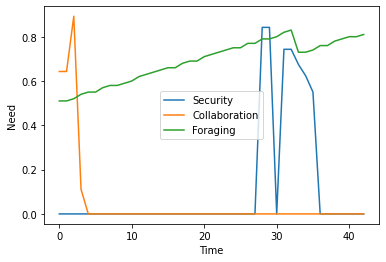

In [27]:
plot(prey2.get_log("security"))
plot(prey2.get_log("collaboration"))
plot(prey2.get_log("foraging"))
legend(["Security", "Collaboration", "Foraging"])

xlabel("Time")
ylabel("Need")

Text(0, 0.5, 'Need')

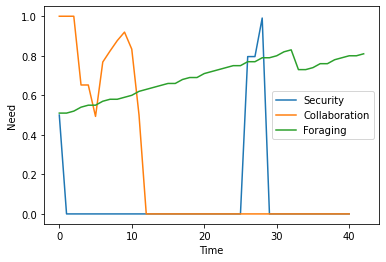

In [28]:
plot(prey3.get_log("security"))
plot(prey3.get_log("collaboration"))
plot(prey2.get_log("foraging"))
legend(["Security", "Collaboration", "Foraging"])

xlabel("Time")
ylabel("Need")

## 3 - Close session

In [ ]:
close_session(simulator)